In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df=pd.read_csv("/content/analyzed_tickets.csv")

In [15]:
df.head(10)

,ticket_id,product,ticket_text,generated_timestamp,sentiment,urgency,category,summary,error,message
0,1,FinanceManager SaaS,"Okay, user wants a realistic bug report for Fi...",2025-09-03 13:18:44,Positive,Medium,Technical Issue,User is generally satisfied with FinanceManage...,NaN,NaN
1,2,StreamFlix Subscription,"Okay, user wants a realistic StreamFlix passwo...",2025-09-03 13:18:44,Positive,Medium,Technical Issue,User successfully resolved their StreamFlix pa...,NaN,NaN
2,3,HomeSecurity Hub,"First, I need to understand the user's query. ...",2025-09-03 13:18:44,Error,Error,Error,Analysis failed,NaN,NaN
3,4,HomeSecurity Hub,"First, I need to understand the user's query. ...",2025-09-03 13:18:44,Negative,Medium,Billing,Invoice discrepancy causing billing issues for...,NaN,NaN
4,5,OfficeSuite 365,"Okay, let me tackle this query. The user wants...",2025-09-03 13:18:44,Positive,Low,Feature Request,"User requests file organization via labels, si...",NaN,NaN
5,6,OfficeSuite 365,"Okay, I'm looking at this query to generate a ...",2025-09-03 13:18:44,Negative,Medium,Technical Issue,Mobile authentication fails with error code 'A...,NaN,NaN
6,7,StreamFlix Subscription,"Okay, let me tackle this query. The user wants...",2025-09-03 13:18:44,Negative,Medium,Billing,Customer is confused about a billing dispute f...,NaN,NaN
7,8,StreamFlix Subscription,"Okay, so the user wants me to generate a reali...",2025-09-03 13:18:44,Negative,High,Account Management,Customer is angry and frustrated about deletin...,NaN,NaN
8,9,CloudSync Pro,"Okay, let me think through this query carefull...",2025-09-03 13:18:44,Error,Error,Error,Analysis failed,NaN,NaN
9,10,ProjectFlow Manager,"Okay, let me think through this request carefu...",2025-09-03 13:18:44,Negative,High,Technical Issue,User reports critical data sync error between ...,NaN,NaN


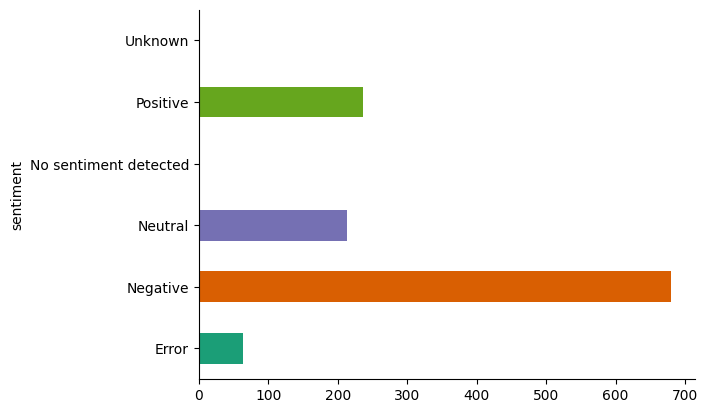

In [16]:
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

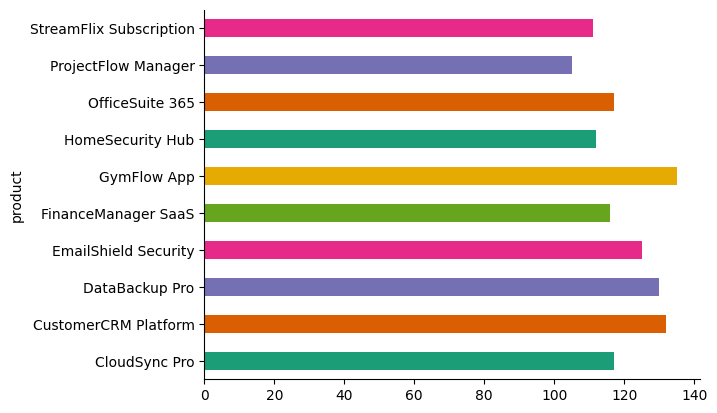

In [17]:
df.groupby('product').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

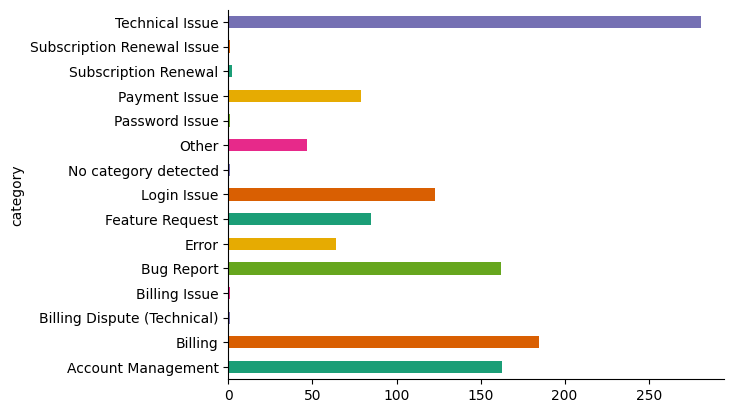

In [18]:
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

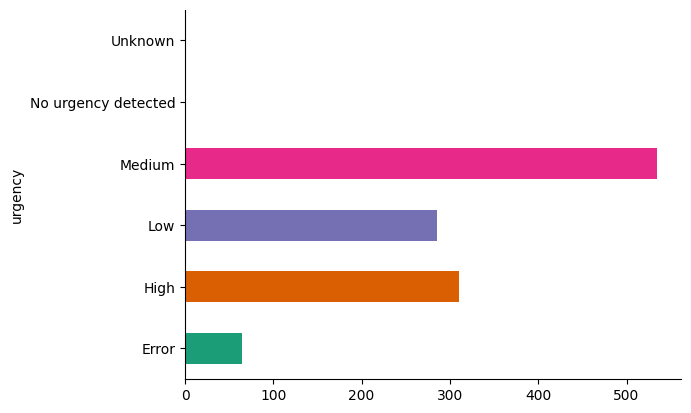

In [19]:
df.groupby('urgency').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
# Drop useless columns (error logs from analysis step)
df = df.drop(columns=["error", "message"], errors="ignore")

# Keep only the relevant columns
expected_cols = ["ticket_id", "ticket_text", "sentiment", "urgency", "category", "summary"]
df = df[[col for col in df.columns if col in expected_cols]]

# Drop rows where key fields are missing
df.dropna(subset=["ticket_text", "sentiment", "urgency", "category"], inplace=True)

print(f"✅ Dataset loaded with {len(df)} valid rows")
print("📊 Columns available:", df.columns.tolist())

# Quick sanity check on labels
print("\n😊 Sentiment distribution:")
print(df["sentiment"].value_counts())
print("\n🚨 Urgency distribution:")
print(df["urgency"].value_counts())
print("\n📋 Category distribution:")
print(df["category"].value_counts())


✅ Dataset loaded with 1196 valid rows
📊 Columns available: ['ticket_id', 'ticket_text', 'sentiment', 'urgency', 'category', 'summary']

😊 Sentiment distribution:
sentiment
Negative                 680
Positive                 237
Neutral                  213
Error                     64
No sentiment detected      1
Unknown                    1
Name: count, dtype: int64

🚨 Urgency distribution:
urgency
Medium                 535
High                   310
Low                    285
Error                   64
No urgency detected      1
Unknown                  1
Name: count, dtype: int64

📋 Category distribution:
category
Technical Issue                281
Billing                        185
Account Management             163
Bug Report                     162
Login Issue                    123
Feature Request                 85
Payment Issue                   79
Error                           64
Other                           47
Subscription Renewal             2
Billing Dispute (Techn

In [21]:
# ================================
# 1. Extra Cleaning of Labels
# ================================

# Drop junk values in sentiment & urgency
invalid_sentiments = ["Error", "No sentiment detected", "Unknown"]
invalid_urgency = ["Error", "No urgency detected", "Unknown"]
invalid_category = ["Error", "No category detected"]

df = df[~df["sentiment"].isin(invalid_sentiments)]
df = df[~df["urgency"].isin(invalid_urgency)]
df = df[~df["category"].isin(invalid_category)]

# Handle rare categories: merge into "Other"
category_counts = df["category"].value_counts()
rare_categories = category_counts[category_counts < 5].index
df["category"] = df["category"].replace(rare_categories, "Other")

print(f"✅ After cleaning, dataset has {len(df)} rows")

# Re-check label balance
print("\n😊 Sentiment distribution:")
print(df["sentiment"].value_counts())
print("\n🚨 Urgency distribution:")
print(df["urgency"].value_counts())
print("\n📋 Category distribution:")
print(df["category"].value_counts())


✅ After cleaning, dataset has 1130 rows

😊 Sentiment distribution:
sentiment
Negative    680
Positive    237
Neutral     213
Name: count, dtype: int64

🚨 Urgency distribution:
urgency
Medium    535
High      310
Low       285
Name: count, dtype: int64

📋 Category distribution:
category
Technical Issue       281
Billing               185
Account Management    163
Bug Report            162
Login Issue           123
Feature Request        85
Payment Issue          79
Other                  52
Name: count, dtype: int64


In [22]:
%pip install catboost

In [24]:
# ================================
# 2. Candidate Models
# ================================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

model_candidates = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "LinearSVC": LinearSVC(class_weight="balanced"),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# ================================
# 3. Training & Evaluation Function
# ================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os, joblib
import pandas as pd

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

def benchmark_models(target_col, task_name):
    print(f"\n🎯 Task: {task_name} (predicting {target_col})")

    X = df["ticket_text"]
    y = df[target_col]

    if len(y.unique()) < 2:
        print(f"⚠️ Skipping {task_name}: only one class available.")
        return pd.DataFrame()

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Train/test split
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    results = []

    for model_name, model in model_candidates.items():
        print(f"\n🚀 Training {model_name}...")
        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
            ("clf", model)
        ])

        pipeline.fit(X_train, y_train_encoded)
        y_pred_encoded = pipeline.predict(X_test)

        # Decode back
        y_pred = le.inverse_transform(y_pred_encoded)
        y_test_decoded = le.inverse_transform(y_test_encoded)

        acc = accuracy_score(y_test_decoded, y_pred)
        f1 = f1_score(y_test_decoded, y_pred, average="weighted")

        # ✅ Print only short summary
        print(f"✅ {model_name}: Accuracy={acc:.3f}, F1={f1:.3f}")

        # Save detailed classification report to file
        report_path = f"figures/{task_name.lower()}_{model_name}_report.txt"
        with open(report_path, "w") as rep_file:
            rep_file.write(classification_report(y_test_decoded, y_pred))

        # Save confusion matrix
        cm = confusion_matrix(y_test_decoded, y_pred, labels=le.classes_)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=le.classes_,
                    yticklabels=le.classes_)
        plt.title(f"{task_name} - {model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        cm_path = f"figures/{task_name.lower()}_{model_name}_cm.png"
        plt.savefig(cm_path, dpi=300)
        plt.close()

        results.append({
            "Task": task_name,
            "Model": model_name,
            "Accuracy": round(acc, 4),
            "F1": round(f1, 4)
        })

    # Pick best model
    results_df = pd.DataFrame(results)
    best_row = results_df.sort_values("F1", ascending=False).iloc[0]

    best_model_name = best_row["Model"]
    print(f"\n🏆 Best model for {task_name}: {best_model_name} (F1={best_row['F1']:.3f})")

    # Retrain on full dataset
    best_model = model_candidates[best_model_name]
    best_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
        ("clf", best_model)
    ])
    best_pipeline.fit(X, y_encoded)

    # Save best model
    model_path = f"models/{task_name.lower()}_best.joblib"
    joblib.dump(best_pipeline, model_path)
    print(f"💾 Saved best {task_name} model → {model_path}")

    return results_df

# ================================
# 4. Run Benchmarks
# ================================
results_sentiment = benchmark_models("sentiment", "Sentiment")
results_urgency = benchmark_models("urgency", "Urgency")
results_category = benchmark_models("category", "Category")

all_results = pd.concat([results_sentiment, results_urgency, results_category], ignore_index=True)
print("\n📊 Benchmark Results:")
print(all_results)

all_results.to_csv("benchmark_results.csv", index=False)
print("💾 Saved benchmark results → benchmark_results.csv")

# ================================
# 5. Generate Evaluation Report
# ================================
report_path = "evaluation_report.md"
with open(report_path, "w") as f:
    f.write("# 📊 Model Evaluation Report\n\n")
    f.write("This report summarizes the benchmarking results for the Sentiment, Urgency, and Category classification tasks.\n\n")

    f.write("## 🏆 Best Models Per Task\n\n")
    for task in ["Sentiment", "Urgency", "Category"]:
        task_results = all_results[all_results["Task"] == task]
        if not task_results.empty:
            best_row = task_results.sort_values("F1", ascending=False).iloc[0]
            f.write(f"- **{task}** → {best_row['Model']} (Accuracy={best_row['Accuracy']:.2f}, F1={best_row['F1']:.2f})\n")
    f.write("\n")

    f.write("## 📋 Full Benchmark Results\n\n")
    f.write(all_results.to_markdown(index=False))
    f.write("\n\n")

    f.write("## 🔎 Confusion Matrices & Reports\n")
    f.write("Confusion matrices (`.png`) and detailed classification reports (`.txt`) for each model are saved in the `figures/` directory.\n")

print(f"💾 Saved evaluation report → {report_path}")



🎯 Task: Sentiment (predicting sentiment)

🚀 Training LogReg...
✅ LogReg: Accuracy=0.801, F1=0.795

🚀 Training NaiveBayes...
✅ NaiveBayes: Accuracy=0.624, F1=0.504


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🚀 Training RandomForest...
✅ RandomForest: Accuracy=0.783, F1=0.739

🚀 Training LinearSVC...
✅ LinearSVC: Accuracy=0.792, F1=0.781

🚀 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:57:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost: Accuracy=0.832, F1=0.826

🚀 Training CatBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ CatBoost: Accuracy=0.836, F1=0.827

🏆 Best model for Sentiment: CatBoost (F1=0.827)
💾 Saved best Sentiment model → models/sentiment_best.joblib

🎯 Task: Urgency (predicting urgency)

🚀 Training LogReg...
✅ LogReg: Accuracy=0.588, F1=0.587

🚀 Training NaiveBayes...
✅ NaiveBayes: Accuracy=0.482, F1=0.324

🚀 Training RandomForest...
✅ RandomForest: Accuracy=0.584, F1=0.556

🚀 Training LinearSVC...
✅ LinearSVC: Accuracy=0.615, F1=0.615

🚀 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:01:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost: Accuracy=0.628, F1=0.621

🚀 Training CatBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ CatBoost: Accuracy=0.611, F1=0.602

🏆 Best model for Urgency: XGBoost (F1=0.621)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:02:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


💾 Saved best Urgency model → models/urgency_best.joblib

🎯 Task: Category (predicting category)

🚀 Training LogReg...
✅ LogReg: Accuracy=0.770, F1=0.767

🚀 Training NaiveBayes...
✅ NaiveBayes: Accuracy=0.327, F1=0.226


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🚀 Training RandomForest...
✅ RandomForest: Accuracy=0.783, F1=0.761


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🚀 Training LinearSVC...
✅ LinearSVC: Accuracy=0.770, F1=0.758

🚀 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:02:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost: Accuracy=0.805, F1=0.790

🚀 Training CatBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ CatBoost: Accuracy=0.814, F1=0.799

🏆 Best model for Category: CatBoost (F1=0.799)
💾 Saved best Category model → models/category_best.joblib

📊 Benchmark Results:
         Task         Model  Accuracy      F1
0   Sentiment        LogReg    0.8009  0.7950
1   Sentiment    NaiveBayes    0.6239  0.5039
2   Sentiment  RandomForest    0.7832  0.7387
3   Sentiment     LinearSVC    0.7920  0.7811
4   Sentiment       XGBoost    0.8319  0.8261
5   Sentiment      CatBoost    0.8363  0.8270
6     Urgency        LogReg    0.5885  0.5872
7     Urgency    NaiveBayes    0.4823  0.3235
8     Urgency  RandomForest    0.5841  0.5563
9     Urgency     LinearSVC    0.6150  0.6151
10    Urgency       XGBoost    0.6283  0.6208
11    Urgency      CatBoost    0.6106  0.6019
12   Category        LogReg    0.7699  0.7670
13   Category    NaiveBayes    0.3274  0.2256
14   Category  RandomForest    0.7832  0.7610
15   Category     LinearSVC    0.7699  0.7580
16   Category       XGBoost    0.8053  0.7897
17   Ca

In [25]:
# ================================
# 6. Visualize Benchmark Results
# ================================
plt.figure(figsize=(10, 6))
sns.barplot(data=all_results, x="Model", y="F1", hue="Task")
plt.title("Model Benchmark Comparison (F1 Score)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.legend(title="Task")
plt.tight_layout()

f1_chart_path = "figures/benchmark_f1_scores.png"
plt.savefig(f1_chart_path, dpi=300)
plt.close()

print(f"📊 Saved F1 comparison chart → {f1_chart_path}")

# Append chart reference to evaluation report
with open(report_path, "a") as f:
    f.write("\n## 📈 F1 Score Comparison Chart\n")
    f.write(f"![F1 Score Comparison]({f1_chart_path})\n")


📊 Saved F1 comparison chart → figures/benchmark_f1_scores.png
